In [56]:
# -*- coding: latin-1 -*-
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import numpy as np
import json

import geocoder

from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer
sa = Blobber(analyzer=NaiveBayesAnalyzer())

sns.set_style('whitegrid')
%matplotlib inline

In [57]:
## Open and read in the tweets file as JSON objects

with open('rmdvv.txt', 'r') as tweets_text:
    tweets_data = []
    for line in tweets_text:
        try:
            tweet = json.loads(line)
            if tweet['text'] is not None:
                tweets_data.append(tweet)
            else:
                print 'Caught'
        except:
            continue

In [58]:
## How many tweets do we have in our collection?


print len(tweets_data)

98805


In [59]:
## Create our dataframe and parse each tweet for the text, language, date/time created, and coordinates if available.


tweets_df = pd.DataFrame()
tweets_df['text'] = map(lambda tweet: tweet.get('text'), tweets_data)
tweets_df['lang'] = map(lambda tweet: tweet.get('lang',None).encode('utf-8'), tweets_data)
tweets_df['created_at'] = map(lambda tweet: tweet.get('created_at',None), tweets_data)
tweets_df['coordinates'] = map(lambda tweet: tweet.get('coordinates','None'), tweets_data)

## Define a function that parses the time per tweet and determines what time period the tweet was sent '
##  'Half time' 'Second Half' 'Full time'

def time_parser(df):
    new_time = df['created_at'].split('Jan 03 ')[1].split(' +')[0].replace(':', '')
    if int(new_time) <= 201900:
        time_class = 'First half'
    elif 201900 < int(new_time) <= 203100:
        time_class = 'Half time'
    else:
        time_class = 'Second half'

    return time_class 

## Define a function to clean the tweets, preparing them for the sentiment analysis

def tweet_cleaner(df):
    text = df['text'].lower().encode('unicode_escape')
    new_tweet = " ".join([word for word in text.split()
                            if 'http' not in word and '\u' not in word and '\U' not in word and "\n" not in word 
                                and not word.startswith('"@')
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and not word.startswith('\U')
                                and not word.startswith('\n')
                                and word != 'rt'
                                and word != '&amp;'
                            ])
    return new_tweet

## Apply functions to dataframe

tweets_df['parsed_time'] = tweets_df.apply(time_parser, axis = 1)
tweets_df['cleaned_tweet'] = tweets_df.apply(tweet_cleaner, axis = 1)


##Parse for user reported locations

locations = []
for tweet in tweets_data:
    try:
        if tweet['user']:
            locations.append(tweet['user']['location'])
        else:
            locations.append('')
    except KeyError:
        locations.append('')
        continue

##Parse for geocoded countries        
        
countries = []
for tweet in tweets_data:
    try:
        if tweet['place']:
            try:
                countries.append(tweet['place']['country'].encode('unicode_escape'))
            except AttributeError:
                continue
        else:
            countries.append('')
    except KeyError:
        countries.append('')
        continue

##Parse for followers count        

followers = []
for tweet in tweets_data:
    try:
        if tweet['user']:
            followers.append(tweet['user']['followers_count'])
        else:
            locations.append('')
    except KeyError:
        followers.append('')
        continue

##Parse for username        
        
username = []
for tweet in tweets_data:
    try:
        if tweet['user']:
            username.append(tweet['user']['screen_name'])
        else:
            username.append('')
    except KeyError:
        username.append('')
        continue

##Parse for retweet check        
        
retweets = []

tweets = tweets_df.iterrows()

for tweet in tweets:
    if tweet[1][0].startswith('RT'):
        retweets.append('Y')
    else:
        retweets.append('N') 


## Add columns
        
tweets_df['username'] = username
tweets_df['country'] = countries
tweets_df['locations'] = locations
tweets_df['followers_count'] = followers
tweets_df['count'] = 1
tweets_df['retweet'] = retweets

## Validate counts

print len(followers)  
print len(username)
print len(countries)
print len(tweets_df)
print len(tweets_df['coordinates'].dropna())
tweets_df.tail()

98805
98805
98805
98805
258


,text,lang,created_at,coordinates,parsed_time,cleaned_tweet,username,country,locations,followers_count,count,retweet
98800,How the fuck did you not score Valencia!?,en,Sun Jan 03 21:18:28 +0000 2016,None,Second half,how the fuck did you not score valencia!?,MikeAlonso10,,None,295,1,N
98801,FT : Valencia 2 vs 2 Real Madrid (Benzema 16' ...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,ft : valencia 2 vs 2 real madrid (benzema 16' ...,yoga_angga77,,"Pekanbaru, RIAU, INDONESIA",420,1,N
98802,RT @realmadrid: FT: Valencia 2-2 Real Madrid (...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,"ft: valencia 2-2 real madrid (@benzema '17, 82...",Aleex_C7,,"Tucuruí, Pará",253,1,Y
98803,Valora a los jugadores del Real Madrid: Leer ...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,valora a los jugadores del real madrid: \xa0leer,mipezdelinfiern,,Bogotá - Colombia,162,1,N
98804,Vaya dos defensas las del Madrid y el Valencia...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,vaya dos defensas las del madrid y el valencia...,futbolicia,,España,234,1,N


In [60]:
## Create coordinates dataframe

cord_df = tweets_df[tweets_df.coordinates != 'None'].dropna()

## Define latitude and longitude parsing functions

def lat_parse(df):
    lat = str(df['coordinates'])
    lat = lat.split("'coordinates': [")[1].split(']')[0]
    lat = lat.split(',')[0]
    return lat

def lon_parse(df):
    lon = str(df['coordinates'])
    lon = lon.split("'coordinates': [")[1].split(']')[0]
    lon = lon.split(',')[1]
    return lon

# Apply functions

cord_df['lat'] = cord_df.apply(lat_parse, axis = 1)
cord_df['lon'] = cord_df.apply(lon_parse, axis = 1)
cord_df[['lat', 'lon']]


cord_df.head()

,text,lang,created_at,coordinates,parsed_time,cleaned_tweet,username,country,locations,followers_count,count,retweet,lat,lon
162,Friends of Valencia,en,Sun Jan 03 19:31:11 +0000 2016,"{u'type': u'Point', u'coordinates': [28.39679,...",First half,friends of valencia,its_mrdee,South Africa,Pretoria,3327,1,N,28.39679,-25.71147
643,Amunt!!!! @valenciacf #valencia #aficio #mesta...,und,Sun Jan 03 19:31:38 +0000 2016,"{u'type': u'Point', u'coordinates': [-0.358361...",First half,amunt!!!! mestalla stadium,djvicenteferrer,Espa\xf1a,Valencia-Ibiza (Spain),4475,1,N,-0.35836111,39.47465556
834,Real Madrid,es,Sun Jan 03 19:31:54 +0000 2016,"{u'type': u'Point', u'coordinates': [27.64601,...",First half,real madrid,STANLEYMANGANYE,South Africa,CENTURION/OLIEVENHOUTBOSCH EXT 37,970,1,N,27.64601,-25.73175
1204,Matchke meepikken ;) Valencia - Real Madrid #v...,en,Sun Jan 03 19:32:25 +0000 2016,"{u'type': u'Point', u'coordinates': [-0.358278...",First half,matchke meepikken ;) valencia - real madrid (@...,SanderoBE,Espa\xf1a,Belgium,259,1,N,-0.35827875,39.47453111
1511,Benítez vuelve a su casa 😍🎙📻 ¡Amunt mi VCF!...,es,Sun Jan 03 19:32:58 +0000 2016,"{u'type': u'Point', u'coordinates': [-0.358812...",First half,ben\xedtez vuelve a su casa \xa1amunt mi vcf! ...,PaulaPPM,Espa\xf1a,Valencia - Oliva - Istanbul,2515,1,N,-0.35881272,39.47442456


In [61]:
team_class = []
rmcf = []
vacf = []
no_pref = []
na = []

## Parse tweets for team context
## 'No pref' = Both teams/ No teams
## 'VACF' = Valencia
## 'RMCF' = Real Madrid
## 'N/A' = Not english

iterd = tweets_df.iterrows()
for t in iterd:
    try:
        if 'valencia' in t[1][0].lower() and 'madrid' not in t[1][0].lower() and t[1][1] == 'en':
            team_class.append('VACF')
            vacf.append('VACF')
        elif 'madrid' in t[1][0].lower() and 'valencia' not in t[1][0].lower() and t[1][1] == 'en':
            team_class.append('RMCF')
            rmcf.append('RMCF')
        elif t[1][1] != 'en':
            team_class.append('N/A')
            na.append('N/A')
        else:
            team_class.append('No pref')
            no_pref.append('no pref')
    except AttributeError:
        print 'Caught'
        
tweets_df['team_class'] = team_class

iterrer = tweets_df.iterrows()
rt = []
rt_count = []
for t in iterrer:
    if t[1][0].startswith('RT'):
        rt.append('Y')
        rt_count.append('rt')
    else:
        rt.append('N')
print len(rt_count)

tweets_df['RT_binary'] = rt
        
print len(team_class)
print len(rmcf)
print len(vacf)
print len(no_pref)
print len(na)
print len(rt_count)
tweets_df.tail()

53083
98805
7432
6670
12512
72191
53083


,text,lang,created_at,coordinates,parsed_time,cleaned_tweet,username,country,locations,followers_count,count,retweet,team_class,RT_binary
98800,How the fuck did you not score Valencia!?,en,Sun Jan 03 21:18:28 +0000 2016,None,Second half,how the fuck did you not score valencia!?,MikeAlonso10,,None,295,1,N,VACF,N
98801,FT : Valencia 2 vs 2 Real Madrid (Benzema 16' ...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,ft : valencia 2 vs 2 real madrid (benzema 16' ...,yoga_angga77,,"Pekanbaru, RIAU, INDONESIA",420,1,N,N/A,N
98802,RT @realmadrid: FT: Valencia 2-2 Real Madrid (...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,"ft: valencia 2-2 real madrid (@benzema '17, 82...",Aleex_C7,,"Tucuruí, Pará",253,1,Y,N/A,Y
98803,Valora a los jugadores del Real Madrid: Leer ...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,valora a los jugadores del real madrid: \xa0leer,mipezdelinfiern,,Bogotá - Colombia,162,1,N,N/A,N
98804,Vaya dos defensas las del Madrid y el Valencia...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,vaya dos defensas las del madrid y el valencia...,futbolicia,,España,234,1,N,N/A,N


In [62]:
## Language distribution

lang_count = tweets_df['lang'].value_counts()
l_df = pd.DataFrame(lang_count, columns = ['count'])[0:10]
l_df

,count
es,58637
en,26614
pt,4613
in,2716
und,1824
fr,1440
tr,1092
it,397
nl,314
ar,173


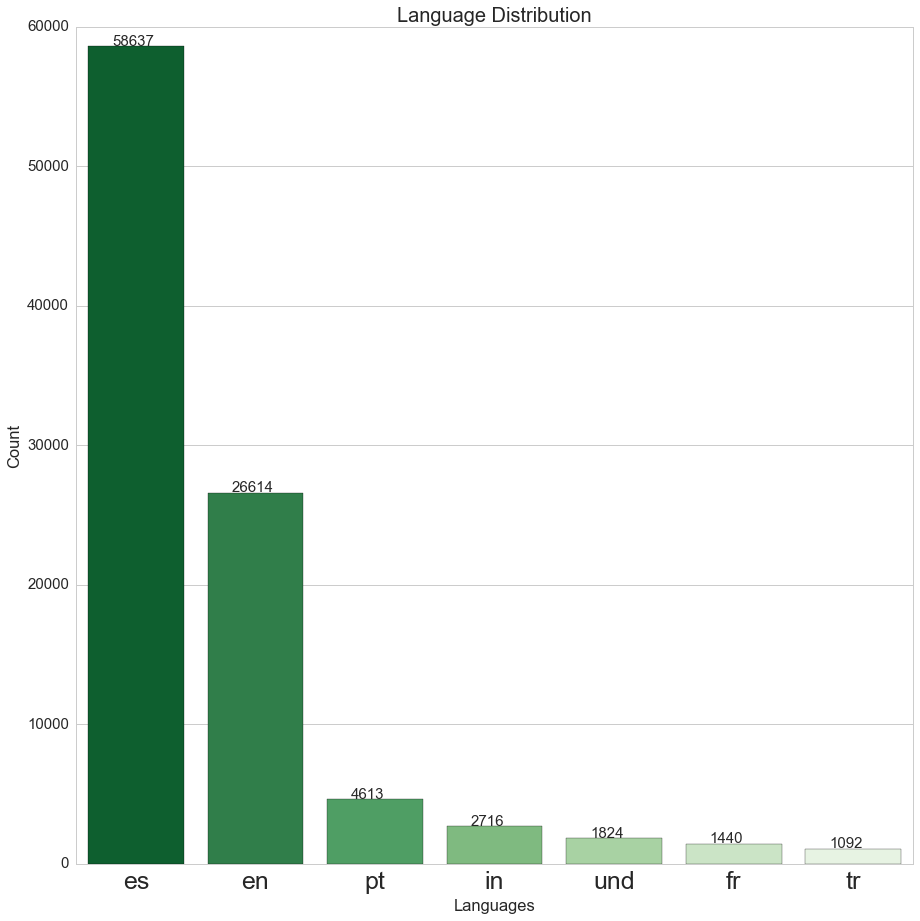

In [63]:
## Plot language distribution

label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size
plt.figure(figsize = (15,15))
plt.title('Language Distribution', size = 20)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
langplt = sns.countplot(x = 'lang', palette= 'Greens_r', data = tweets_df, order=['es','en','pt','in','und', 'fr', 'tr'])
plt.xlabel('Languages')
plt.ylabel('Count')

for p in langplt.patches:
        langplt.annotate(int(p.get_height()), (p.get_x() + 0.2, p.get_height() + 50), size = 15)

In [64]:
cnty_count = tweets_df['country'].value_counts()
c_df = pd.DataFrame(cnty_count, columns = ['count'])[1:10]
top10 = c_df.index
print top10

Index([u'Espa\xf1a', u'United Kingdom', u'Brasil', u'United States',
       u'Colombia', u'Argentina', u'Venezuela', u'South Africa',
       u'T\xfcrkiye'],
      dtype='object')


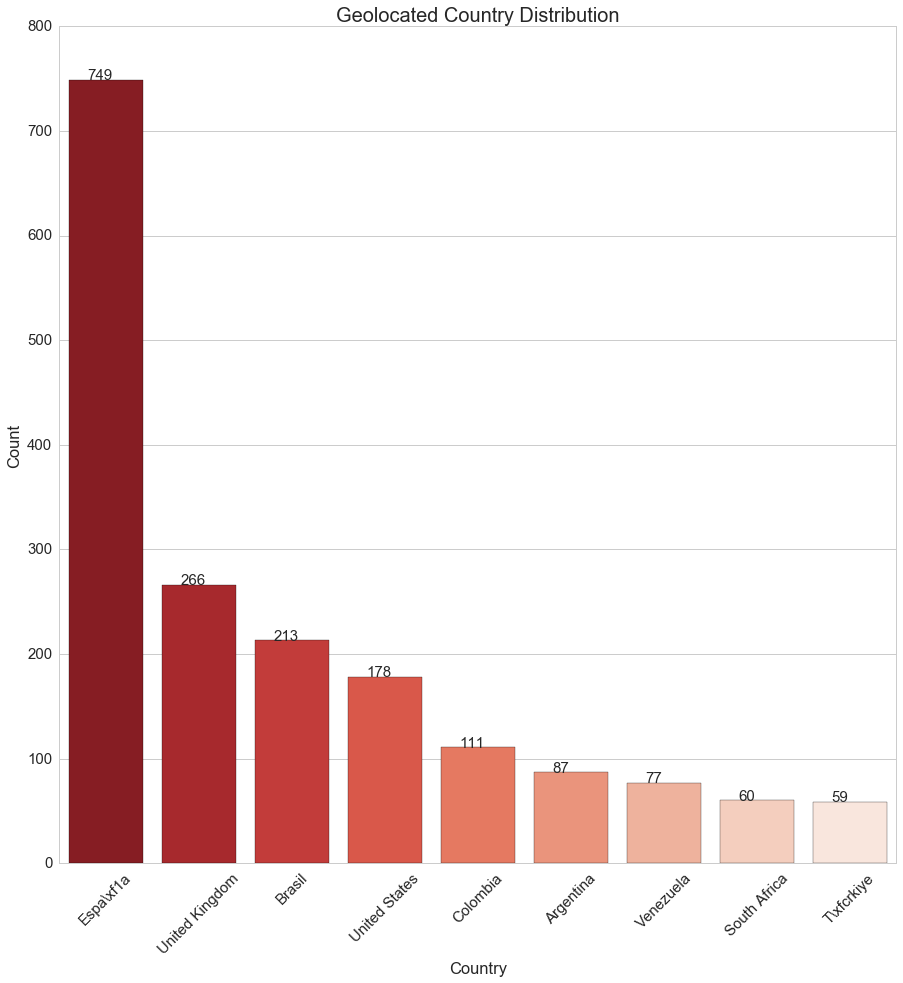

In [65]:
## Plot geolocated country distribution

plt.figure(figsize = (15,15))
plt.title('Geolocated Country Distribution', size = 20)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
cntplot = sns.countplot(x = 'country', palette= 'Reds_r', data = tweets_df,order= top10)
for item in cntplot.get_xticklabels():
    item.set_rotation(45)
plt.xlabel('Country')
plt.ylabel('Count')
for p in cntplot.patches:
        cntplot.annotate(int(p.get_height()), (p.get_x()+0.2, p.get_height()+ 0.5), size = 15)

In [66]:
user_loc = tweets_df['locations'].value_counts()
loc_df = pd.DataFrame(user_loc, columns = ['count'])[0:10]
top10 = loc_df.index[0:10]
print top10

Index([                     u'Madrid',                      u'España',
                         u'Venezuela',               u'United States',
                         u'Indonesia',                    u'Valencia',
                         u'Barcelona',                 u'El Salvador',
                         u'Guatemala', u'Madrid, Comunidad de Madrid'],
      dtype='object')


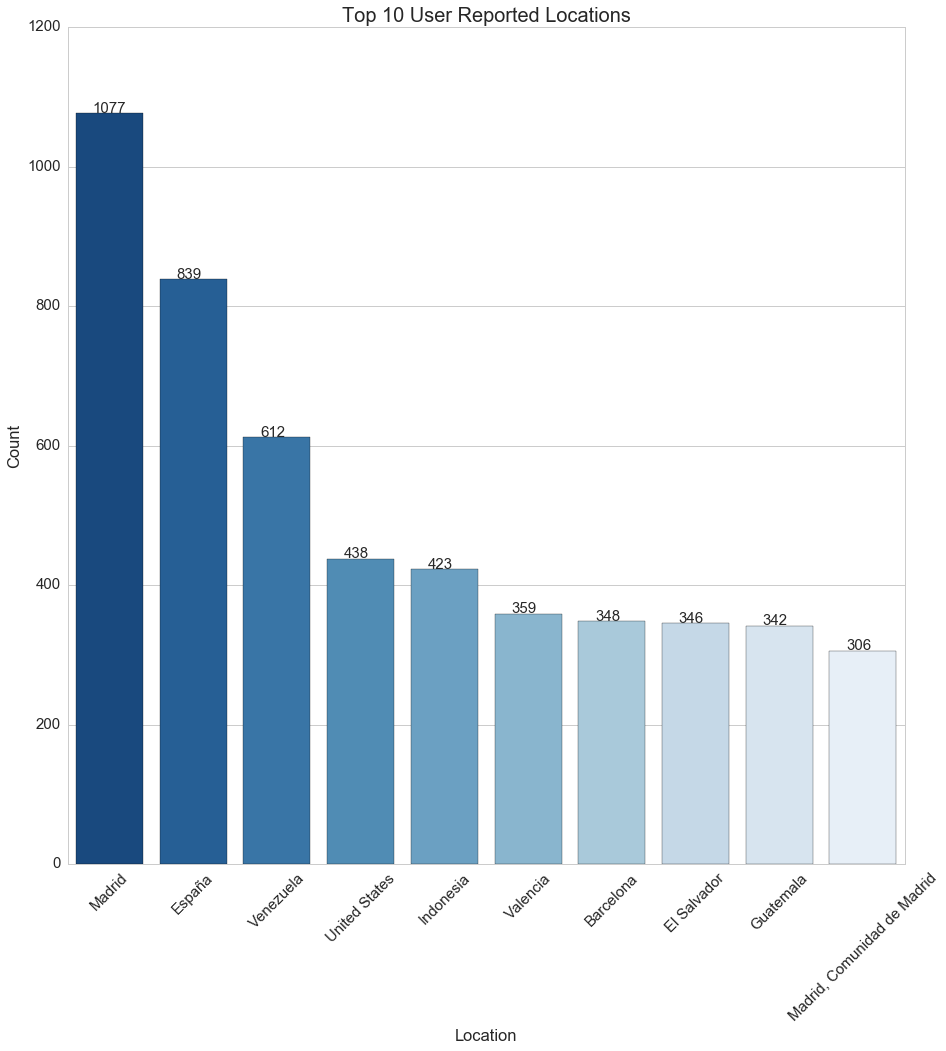

In [67]:
## Plot user reported locations distribution

plt.figure(figsize = (15,15))
plt.title('Top 10 User Reported Locations', size = 20)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
usrlocplot = sns.countplot(x = 'locations', palette= 'Blues_r',data = tweets_df, order= top10)
plt.xlabel('Location')
plt.ylabel('Count')
for item in usrlocplot.get_xticklabels():
    item.set_rotation(45)

for p in usrlocplot.patches:
        usrlocplot.annotate(int(p.get_height()), (p.get_x()+0.2, p.get_height()+ 0.5), size = 15)

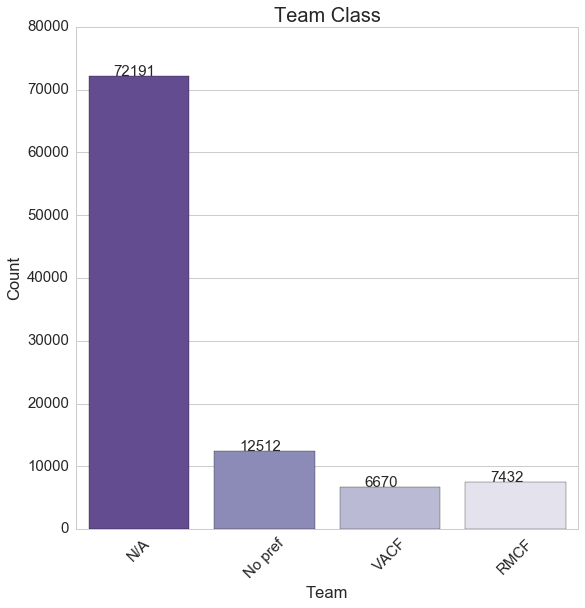

In [68]:
## Plot team classification distribution

plt.figure(figsize = (9,9))
plt.title('Team Class', size = 20)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
tclassplot = sns.countplot(x = 'team_class',palette= 'Purples_r',data = tweets_df)
plt.xlabel('Team')
plt.ylabel('Count')
for item in tclassplot.get_xticklabels():
    item.set_rotation(45)

for p in tclassplot.patches:
        tclassplot.annotate(int(p.get_height()), (p.get_x()+0.2, p.get_height()+ 50), size = 15)

In [69]:
cord_df.head()

,text,lang,created_at,coordinates,parsed_time,cleaned_tweet,username,country,locations,followers_count,count,retweet,lat,lon
162,Friends of Valencia,en,Sun Jan 03 19:31:11 +0000 2016,"{u'type': u'Point', u'coordinates': [28.39679,...",First half,friends of valencia,its_mrdee,South Africa,Pretoria,3327,1,N,28.39679,-25.71147
643,Amunt!!!! @valenciacf #valencia #aficio #mesta...,und,Sun Jan 03 19:31:38 +0000 2016,"{u'type': u'Point', u'coordinates': [-0.358361...",First half,amunt!!!! mestalla stadium,djvicenteferrer,Espa\xf1a,Valencia-Ibiza (Spain),4475,1,N,-0.35836111,39.47465556
834,Real Madrid,es,Sun Jan 03 19:31:54 +0000 2016,"{u'type': u'Point', u'coordinates': [27.64601,...",First half,real madrid,STANLEYMANGANYE,South Africa,CENTURION/OLIEVENHOUTBOSCH EXT 37,970,1,N,27.64601,-25.73175
1204,Matchke meepikken ;) Valencia - Real Madrid #v...,en,Sun Jan 03 19:32:25 +0000 2016,"{u'type': u'Point', u'coordinates': [-0.358278...",First half,matchke meepikken ;) valencia - real madrid (@...,SanderoBE,Espa\xf1a,Belgium,259,1,N,-0.35827875,39.47453111
1511,Benítez vuelve a su casa 😍🎙📻 ¡Amunt mi VCF!...,es,Sun Jan 03 19:32:58 +0000 2016,"{u'type': u'Point', u'coordinates': [-0.358812...",First half,ben\xedtez vuelve a su casa \xa1amunt mi vcf! ...,PaulaPPM,Espa\xf1a,Valencia - Oliva - Istanbul,2515,1,N,-0.35881272,39.47442456


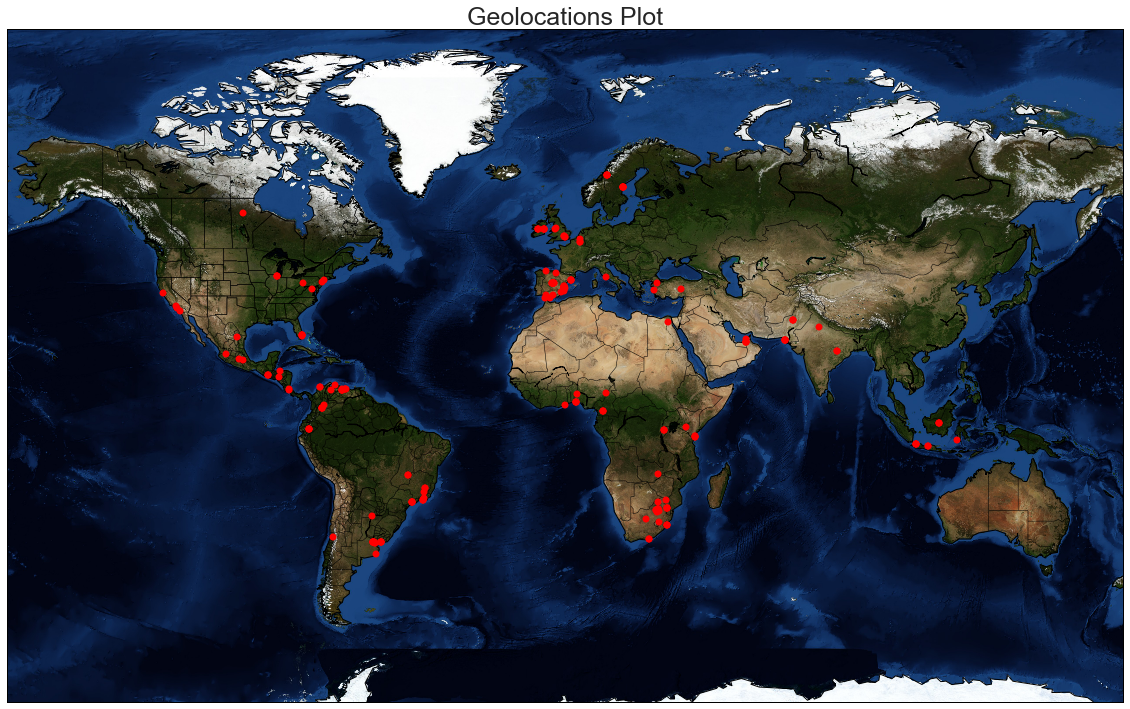

In [70]:
## Plot geolocated tweets

plt.figure(figsize=(20,20))

m = Basemap(projection='mill',llcrnrlat= -70,urcrnrlat=86,\
                llcrnrlon=-170,urcrnrlon=170,resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#FFFFFF')
m.bluemarble()

corditer = cord_df.iterrows()

re_geo_df = pd.DataFrame()
geo_cit = []
geo_cnty = []

for c in corditer:
    lat = float(c[1][12])
    lon = float(c[1][13])
    
    g = geocoder.google([lon, lat], method='reverse')
    #print g.city,', ',g.country_long
    
    geo_cit.append(g.city)
    geo_cnty.append(g.country_long)
    
    xpt,ypt = m(lat,lon)
    m.plot(xpt,ypt, 'ro', markersize= 7)


plt.title("Geolocations Plot", size = 25)

plt.show()

In [71]:
## Dataframe of re-geolocated lat and lons to actual location names

re_geo_df['City'] = geo_cit
re_geo_df['Country'] = geo_cnty

re_geo_df.dropna()

,City,Country
0,Pretoria,South Africa
1,València,Spain
2,Modderspruit,South Africa
3,València,Spain
4,València,Spain
5,São Paulo,Brazil
6,Mulhuddart,Ireland
7,Antwerpen,Belgium
8,Tunja,Colombia
9,Dubai,United Arab Emirates


In [72]:
##Define a function that parses the time per tweet and determines which 5 minute interval
##the tweet was sent during.

def minute_parser(df):
    new_time = df['created_at'].split('Jan 03 ')[1].split(' +')[0].replace(':', '')
    if 193000 < int(new_time) <= 193500:
        time_class = 5
        return time_class
    elif 193500 < int(new_time) <= 194000:
        time_class = 10
        return time_class
    elif 194000 < int(new_time) <= 194500:
        time_class = 15
        return time_class
    elif 194500 < int(new_time) <= 195000:
        time_class = 20
        return time_class
    elif 195000 < int(new_time) <= 195500:
        time_class = 25
        return time_class
    elif 195500 < int(new_time) <= 200000:
        time_class = 30
        return time_class
    elif 200000 < int(new_time) <= 200500:
        time_class = 35
        return time_class
    elif 200500 < int(new_time) <= 201000:
        time_class = 40
        return time_class
    elif 201000 < int(new_time) <= 201700:
        time_class = 45
        return time_class
    elif 201700 < int(new_time) <= 202000:
        time_class = 'Half time'
        return time_class
    elif 202000 < int(new_time) <= 202500:
        time_class = 'Half time'
        return time_class
    elif 202500 < int(new_time) <= 203000:
        time_class = 'Half time'
        return time_class
    elif 203000 < int(new_time) <= 203500:
        time_class = 50
        return time_class
    elif 203500 < int(new_time) <= 204000:
        time_class = 55
        return time_class
    elif 204000 < int(new_time) <= 204500:
        time_class = 60
        return time_class
    elif 204500 < int(new_time) <= 205000:
        time_class = 65
        return time_class
    elif 205000 < int(new_time) <= 205600:
        time_class = 70
        return time_class
    elif 205600 < int(new_time) <= 210000:
        time_class = 75
        return time_class
    elif 210000 < int(new_time) <= 210500:
        time_class = 80
        return time_class
    elif 210500 < int(new_time) <= 211000:
        time_class = 85
        return time_class
    elif 211000 < int(new_time) <= 211830:
        time_class = 90
        return time_class
    else:
        return 'none'
        print 'NA'


tweets_df['parsed_minute'] = tweets_df.apply(minute_parser, axis = 1)
tweets_df.tail()

,text,lang,created_at,coordinates,parsed_time,cleaned_tweet,username,country,locations,followers_count,count,retweet,team_class,RT_binary,parsed_minute
98800,How the fuck did you not score Valencia!?,en,Sun Jan 03 21:18:28 +0000 2016,None,Second half,how the fuck did you not score valencia!?,MikeAlonso10,,None,295,1,N,VACF,N,90
98801,FT : Valencia 2 vs 2 Real Madrid (Benzema 16' ...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,ft : valencia 2 vs 2 real madrid (benzema 16' ...,yoga_angga77,,"Pekanbaru, RIAU, INDONESIA",420,1,N,N/A,N,90
98802,RT @realmadrid: FT: Valencia 2-2 Real Madrid (...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,"ft: valencia 2-2 real madrid (@benzema '17, 82...",Aleex_C7,,"Tucuruí, Pará",253,1,Y,N/A,Y,90
98803,Valora a los jugadores del Real Madrid: Leer ...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,valora a los jugadores del real madrid: \xa0leer,mipezdelinfiern,,Bogotá - Colombia,162,1,N,N/A,N,90
98804,Vaya dos defensas las del Madrid y el Valencia...,es,Sun Jan 03 21:18:28 +0000 2016,None,Second half,vaya dos defensas las del madrid y el valencia...,futbolicia,,España,234,1,N,N/A,N,90


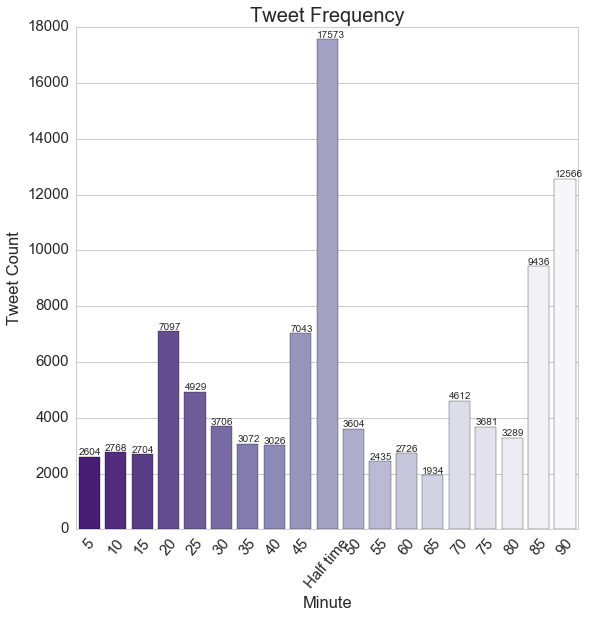

In [73]:
## Plot tweet frequencies per 5 minute intervals

plt.figure(figsize = (9,9))
plt.title('Tweet Frequency', size = 20)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
tclassplot = sns.countplot(x = 'parsed_minute', palette= 'Purples_r',data = tweets_df)
plt.xlabel('Minute')
plt.ylabel('Tweet Count')
for item in tclassplot.get_xticklabels():
    item.set_rotation(50)

for p in tclassplot.patches:
        tclassplot.annotate(int(p.get_height()), (p.get_x(), p.get_height()+ 50), size = 10)
        

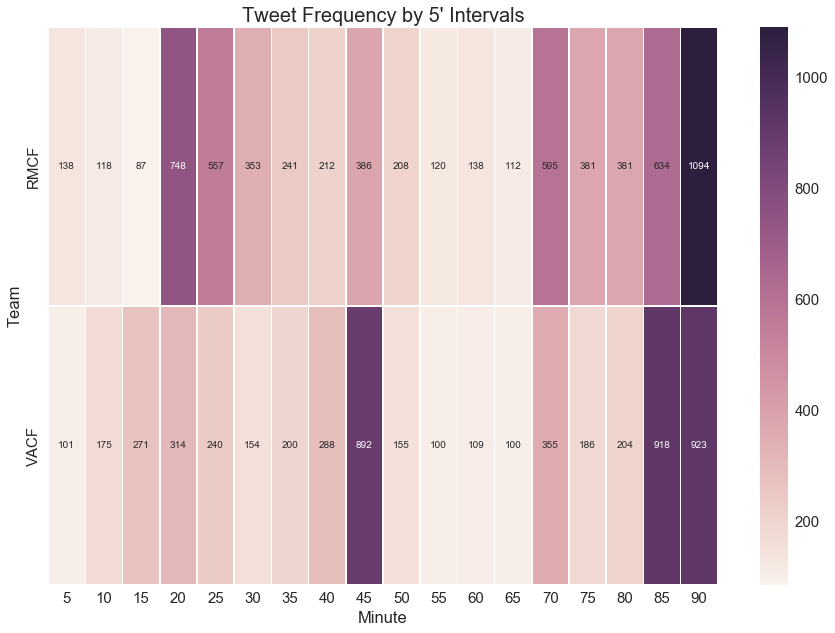

In [74]:
## Heatmap of tweet frequencies per team per 5 minute interval

df = tweets_df[tweets_df.parsed_minute != 'Half time']
dff = df[df.team_class != 'N/A']
dfff = dff[dff.team_class != 'No pref']

nahm_pivot = dfff.pivot_table('count',
                                index='team_class',
                                columns='parsed_minute', aggfunc='sum')

plt.figure(figsize = (15,10))
plt.title("Tweet Frequency by 5' Intervals", size = 20)
sns.heatmap(nahm_pivot, annot= True, fmt= '.9g', linewidths=.5)
plt.xlabel('Minute')
plt.ylabel('Team')

In [75]:
## Define sentiment analysis function

def sentiment_analyzer(df):
    if df['lang'] == 'en':
        tweet = str(df['cleaned_tweet'])
        score = float(round(sa(tweet).sentiment[1], 2))
        return score
    else:
        return None

tweets_df['sent_score'] = tweets_df.apply(sentiment_analyzer, axis = 1)


General sentiment mean: 0.766395130382
Real Madrid sentiment mean: 0.7675
Valencia sentiment mean: 0.761856071964


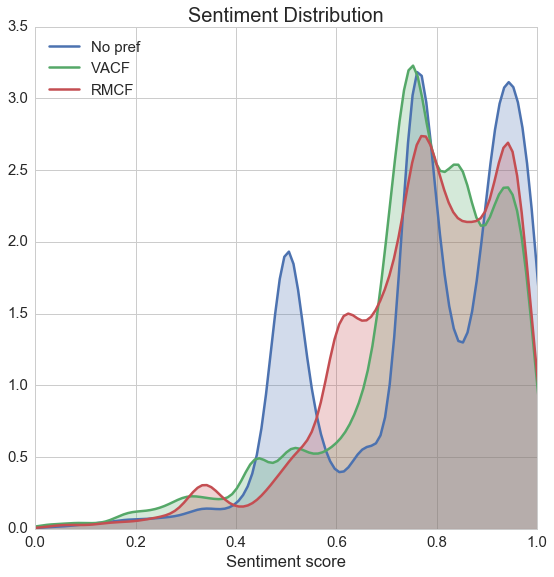

In [76]:
##Plot out sentiment distribution of tweets from our collection

## Sentiment is plotted on a scale of 0 (most negative) to (1 most positive)
va_df = tweets_df[tweets_df.team_class == 'VACF']
rm_df = tweets_df[tweets_df.team_class == 'RMCF']
np_df = tweets_df[tweets_df.team_class == 'No pref']
plt.figure(figsize = (9,9))
plt.title('Sentiment Distribution', size = 20)

sent_distplot = sns.kdeplot(np_df.sent_score.dropna(), shade = True)

sns.kdeplot(va_df.sent_score.dropna(), shade = True)
sns.kdeplot(rm_df.sent_score.dropna(), shade = True)
plt.xlim([0, 1])
plt.legend(['No pref', 'VACF', 'RMCF'], loc= 'best')
plt.ylim([0,3.5])

plt.xlabel('Sentiment score')



print 'General sentiment mean: ' +  str(tweets_df.sent_score.dropna().mean())
print 'Real Madrid sentiment mean: ' + str(rm_df.sent_score.dropna().mean())
print 'Valencia sentiment mean: ' +  str(va_df.sent_score.dropna().mean())
